In [1]:
1

1

In [22]:
# Import necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import requests
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from itertools import cycle

# Load Dataset
data = pd.read_csv("Merged.csv")

# Display first few rows
print(data.head())

# Check for missing values
print("\n🔍 Missing values before cleaning:\n", data.isnull().sum())

# Drop missing values
data = data.dropna()

# Correct label inconsistencies
label_corrections = {
    "Neutural": "Neutral", "Meutral": "Neutral", "N EUTRAL": "Neutral",
    "NEUTRANEG": "Neutral", "Negetive": "Negative", "NEGNEG": "Negative",
    "Negativee": "Negative", "NEG": "Negative"
}
data['tag'] = data['tag'].replace(label_corrections)

# Remove 'Neutral' rows
data = data[data['tag'] != 'Neutral']

# Identify positive class dynamically
unique_labels = data['tag'].unique()
positive_class_label = unique_labels[0]

# Balance dataset by removing excess positive rows
positive_class = data[data['tag'] == positive_class_label]
if len(positive_class) >= 8200:
    rows_to_remove = positive_class.sample(n=8200, random_state=42)
    data = data.drop(rows_to_remove.index)

# Define text and target columns
text_column = 'comment'
target_column = 'tag'

# Split dataset into train and test sets
df_train, df_test = train_test_split(data, test_size=0.2, random_state=42)

# Load Bangla stopwords
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-bn/master/stopwords-bn.txt"
response = requests.get(stopwords_url)
if response.status_code == 200:
    stop_words_bangla = set(response.text.splitlines())

    # Remove stopwords from train and test data
    df_train[text_column] = df_train[text_column].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_bangla]))
    df_test[text_column] = df_test[text_column].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_bangla]))

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(df_train[text_column])
X_test_tfidf = tfidf_vectorizer.transform(df_test[text_column])

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train[target_column])
y_test = label_encoder.transform(df_test[target_column])

print("\n✅ Step 2: TF-IDF Vectorization done!")

# Implement C4.5 (using DecisionTreeClassifier with 'entropy' criterion)
c45_model = DecisionTreeClassifier(criterion='entropy', random_state=42)
c45_model.fit(X_train_tfidf, y_train)

print("\n✅ Step 3: C4.5 (DecisionTreeClassifier) model trained!")

# Predictions
y_pred = c45_model.predict(X_test_tfidf)

                                             comment       tag
0  আলহামদুলিল্লাহ সোনার বাংলার সোনার ছেলেরা দেশকে...  Positive
1                                           মাশাল্লা  Positive
2                                          এগিয়ে যাও  Positive
3                                            চমৎকার।  Positive
4  দেশের শিল্প পতিদের উচিত দেশিও প্রযুক্তি গুলোকে...   Neutral

🔍 Missing values before cleaning:
 comment    0
tag        5
dtype: int64

✅ Step 2: TF-IDF Vectorization done!

✅ Step 3: C4.5 (DecisionTreeClassifier) model trained!


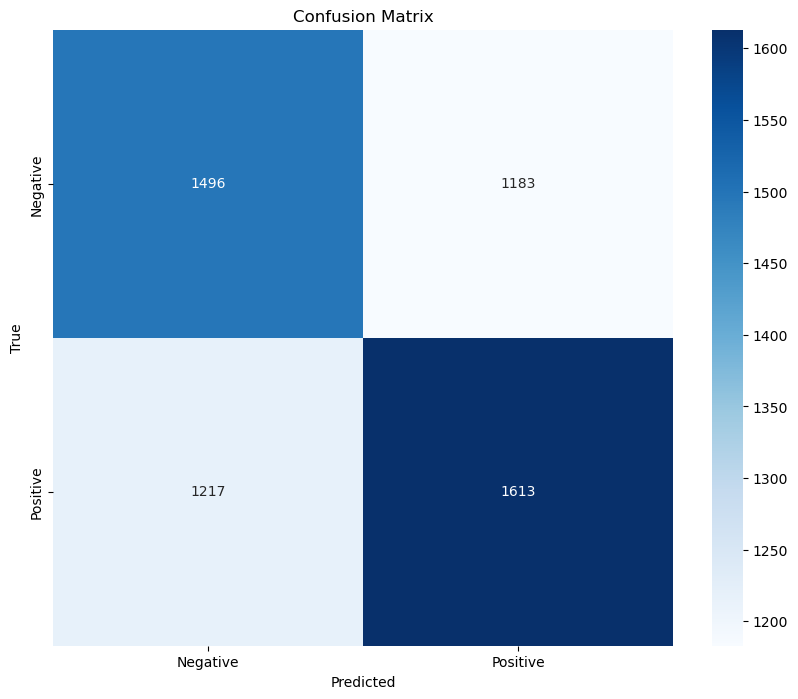

In [23]:
# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_labels = label_encoder.classes_

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [24]:
# 2. Classification Report
print("\n📝 Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))


📝 Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.56      0.55      2679
           1       0.58      0.57      0.57      2830

    accuracy                           0.56      5509
   macro avg       0.56      0.56      0.56      5509
weighted avg       0.56      0.56      0.56      5509



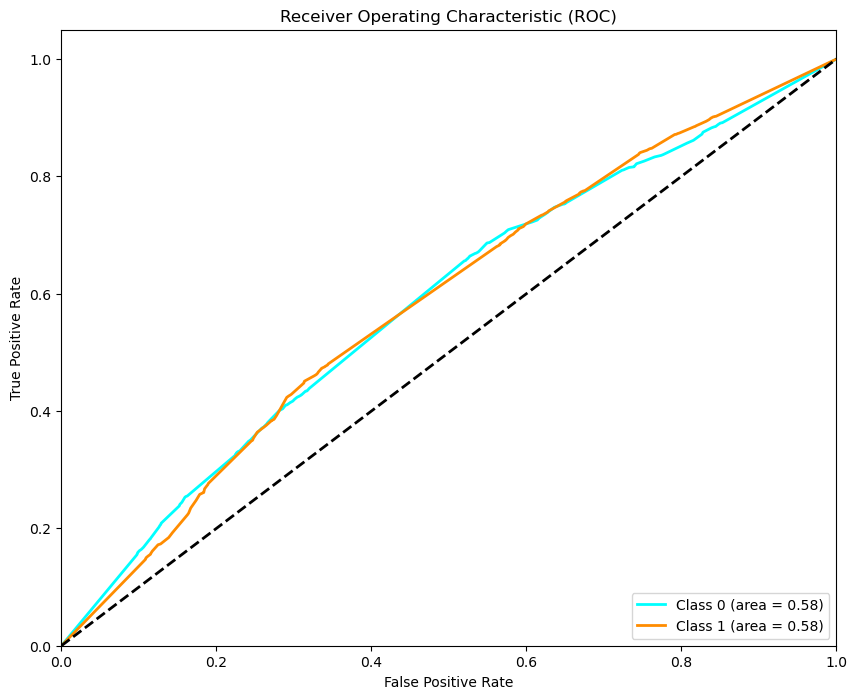

In [25]:
# 3. ROC Curve
n_classes = len(label_encoder.classes_)
y_bin = tf.one_hot(y_test, n_classes)

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], c45_model.predict_proba(X_test_tfidf)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

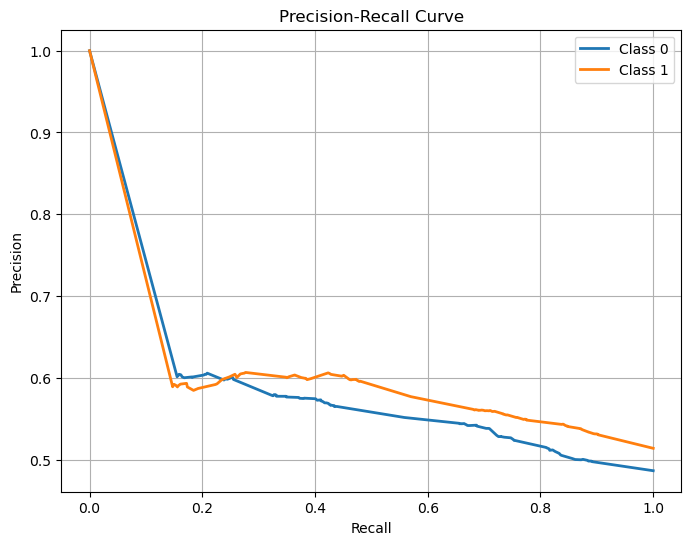


✅ Step 4: Evaluation metrics generated!


In [26]:
# 4. Precision-Recall Curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], c45_model.predict_proba(X_test_tfidf)[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.grid()
plt.show()

print("\n✅ Step 4: Evaluation metrics generated!")